In [43]:
import itertools
import pickle
import numpy as np
import pandas as pd

from music21 import *
from matplotlib import pyplot as plt
from sklearn import svm, naive_bayes, neighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

import data_loader as loader

In [44]:
def fit(x_train,y_train, x_test, y_test,classifiers):
    for clf in classifiers:
        clf.fit(x_train,y_train)
        print(clf)
        print(f"acc: {clf.score(x_test,y_test)}","\n")

In [45]:
def find_k(x_train,y_train, x_test, y_test):
    best_acc = 0
    k = 0
    for i in range(1,30):
        k_nn = neighbors.KNeighborsClassifier(n_neighbors=i)
        k_nn.fit(x_train, y_train)
        acc = k_nn.score(x_test,y_test)
        if(acc>best_acc):
            best_acc = acc
            k = i
    print(f"best k = {k}, best acc = {best_acc}")
    return k

In [46]:
def fit_ngrams(x_train,y_train,x_test,y_test,n):    
    ngrams_train, ngrams_test = ngrams_vectorize(x_train, x_test,n)
    
    k = find_k(ngrams_train,y_train,ngrams_test,y_test)
    fit(ngrams_train,y_train,ngrams_test,y_test,
         [neighbors.KNeighborsClassifier(n_neighbors=k), naive_bayes.MultinomialNB(),svm.LinearSVC(dual=False)])
    

In [47]:
def ngrams_vectorize(x_train,x_test,n):
    print("n =",n)
    
    ngram_vectorizer = CountVectorizer(token_pattern="\d+", ngram_range=(1, n))
    ngrams_train = ngram_vectorizer.fit_transform(x_train)
    ngrams_test = ngram_vectorizer.transform(x_test)

    print("train shape =", ngrams_train.shape)
    print("test shape =", ngrams_test.shape)
    
    return ngrams_train, ngrams_test

In [48]:
def combine(x1,x2,x1_classes):
    result =[]
    for a,b in zip (x1,x2):
        result.append(x1_classes * b + a)
    return result

In [49]:
def combine_item(x1,x2,x1_classes):
    return x1_classes * x2 + x1

In [50]:
def unique_dict(in_list):
    dic = dict.fromkeys(in_list)
    for i,k in enumerate(dic.keys()):
        dic[k]=i
    return dic

In [51]:
def values_to_labels(in_list,dic):
    out_list = [dic[x] for x in in_list]
    return out_list        

In [52]:
def stringify_items(in_list):
    return [str(x) for x in in_list]

In [53]:
# Define known chords
chords_list = ([0], [0,4,7],[0,3,7],[0,5,7],[0,4,8],[0,3,6],[0,4,7,9],[0,3,7,9],
[0,4,7,10],[0,4,7,11],[0,3,7,10],[0,3,6,10],[0,3,6,9],[0,2,4,7,11],
[0,2,4,7,10],[0,1,4,7,10],[0,2,3,7,10])

# chord_types_list = [tone,major, minor, suspended, augmented, 
#                     diminished, major_sixth, minor_sixth, 
#                     dominant_seventh, major_seventh, 
#                     minor_seventh, half_diminished_seventh, 
#                     diminished_seventh, major_ninth, 
#                     dominant_ninth, dominant_minor_ninth, minor_ninth]

In [54]:
def find_chord(in_list):
    root = in_list[0]
    if(len(in_list)==1):
        return root
    costs = []
    for chord in chords_list:
        cost = 0
        for tone_p, tone_ch in itertools.zip_longest(in_list[1:],chord):
            if(tone_p == None or tone_ch == None):
                cost += 3
            else:
                cost+= abs(tone_p - tone_ch)
        costs.append(cost)
    i = list.index(costs,min(costs))
    return combine_item(root,i,12)
        

## Loading data

In [55]:
%%capture
composerNames = ["debussy","tchaikovsky","mozart","victoria","beethoven"]
dataset_type = "chords_t"
x_train_ch, x_test_ch,y_train, y_test = loader.load(dataset_type,composerNames)

In [56]:
lens =[]
for i,comp in enumerate(composerNames):
    lens.append([len(example) for example,y in zip(x_train_ch,y_train) if y==i])
    
df = pd.DataFrame(lens)
df=df.transpose()
df.columns=composerNames
df.describe()

,debussy,tchaikovsky,mozart,victoria,beethoven
count,119.000000,165.000000,423.000000,188.000000,380.000000
mean,2598.857143,4080.163636,4366.028369,1286.659574,6752.355263
std,3130.408684,5055.885499,4103.791556,673.145066,6075.072023
min,369.000000,428.000000,414.000000,451.000000,479.000000
25%,948.500000,1074.000000,1441.500000,767.750000,2219.750000
50%,1505.000000,2061.000000,3153.000000,1094.000000,4728.000000
75%,2434.000000,4647.000000,5826.500000,1620.750000,9111.000000
max,18528.000000,24824.000000,26675.000000,3315.000000,29833.000000


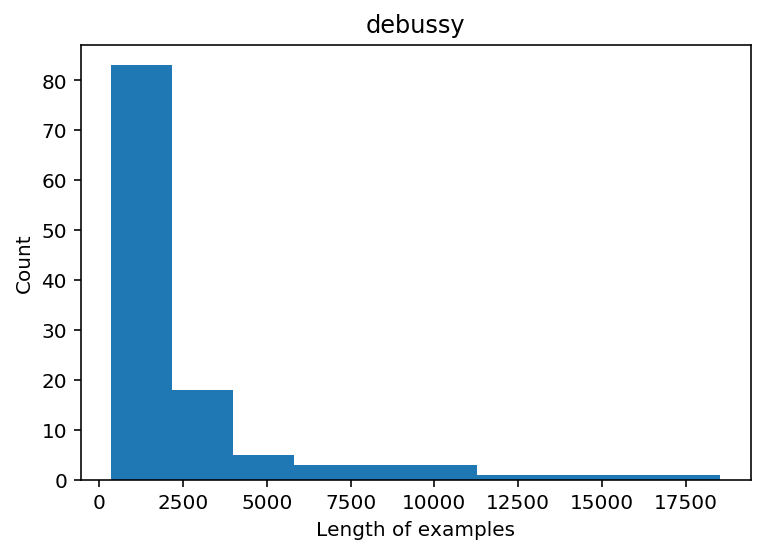

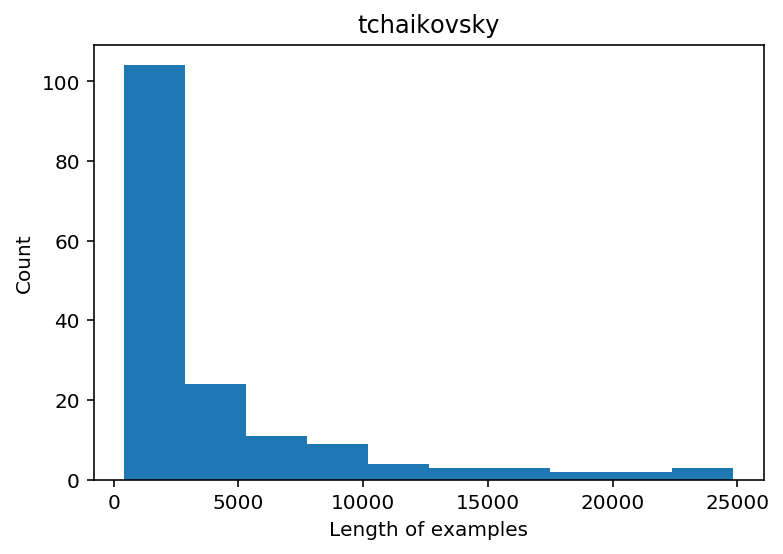

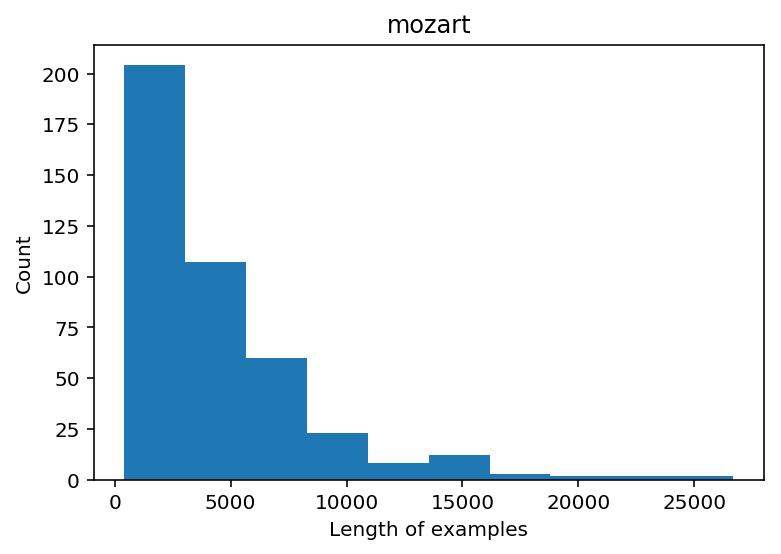

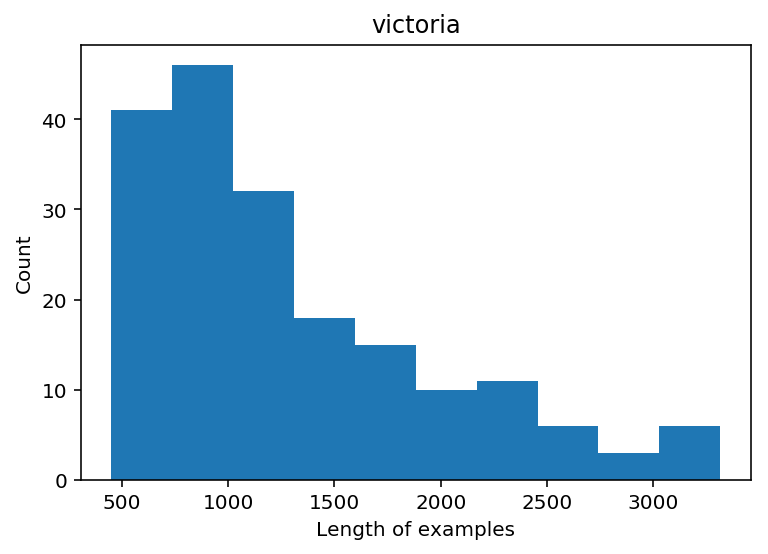

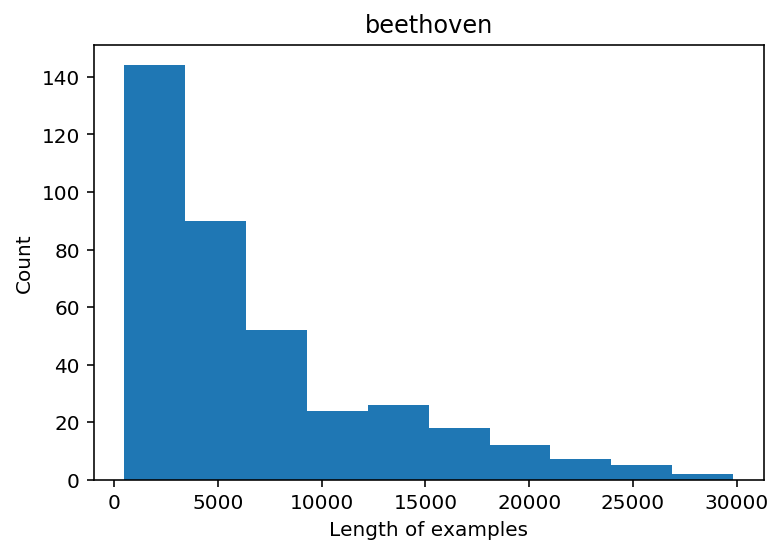

In [57]:
# the histogram of the data
for i,comp in enumerate(composerNames):
    plt.hist(lens[i])
    plt.xlabel("Length of examples")
    plt.ylabel("Count")
    plt.title(comp)
    plt.show()

In [58]:
counts = [loader.get_data_counts(y_train,composerNames),loader.get_data_counts(y_test,composerNames)]
pd.DataFrame(counts,index=["train","test"])

,beethoven,debussy,mozart,tchaikovsky,victoria
train,380,119,423,165,188
test,61,40,124,54,61


In [59]:
x_train = [str([chord[0] for chord in example ]) for example in x_train_ch]
x_test = [str([chord[0] for chord in example]) for example in x_test_ch]

In [60]:
x_train_d, x_test_d,y_train, y_test = loader.load("durations",composerNames)

In [61]:
# x_train = [str([find_chord(chord) for chord in example ]) for example in x_train_ch]
# x_test = [str([find_chord(chord) for chord in example])for example in x_test_ch]

In [62]:
# pitches_seq = list(itertools.chain.from_iterable(x_train_ch+x_test_ch))
# pitches_dict = unique_dict(pitches_seq)

# x_train_ch = [values_to_labels(example,pitches_dict) for example in x_train_ch]
# x_test_ch = [values_to_labels(example,pitches_dict) for example in x_test_ch]

# durations_seq = list(itertools.chain.from_iterable(x_train_d+x_test_d))
# durations_dict = unique_dict(durations_seq)

# x_train_d = [values_to_labels(example,durations_dict) for example in x_train_d]
# x_test_d = [values_to_labels(example,durations_dict) for example in x_test_d]

In [63]:
# x_train = list(map(str, combine(x_train_ch,x_train_d,len(pitches_dict))))
# x_test = list(map(str, combine(x_test_ch,x_test_d,len(pitches_dict))))

# Benchmarking models

In [ ]:
x_train,y_train = loader.shuffle_data(x_train,y_train)
x_test,y_test = loader.shuffle_data(x_test,y_test)

for n in range(1,5):
    fit_ngrams(x_train,y_train,x_test,y_test,n)

n = 1
train shape = (1275, 12)
test shape = (340, 12)
best k = 6, best acc = 0.65
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')
acc: 0.65 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
acc: 0.6 

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
acc: 0.6529411764705882 

n = 2
train shape = (1275, 156)
test shape = (340, 156)
best k = 2, best acc = 0.7176470588235294
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')
acc: 0.7176470588235294 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
acc: 0.6588235294117647 

LinearSVC(C=1.0, class_weight=None, dual=False, fit_inter

# Training a model

In [ ]:
ngram_vectorizer = CountVectorizer(token_pattern="\d+", ngram_range=(1, 4))
ngrams_train = ngram_vectorizer.fit_transform(x_train)
ngrams_test = ngram_vectorizer.transform(x_test)

print("train shape =", ngrams_train.shape)
print("test shape =", ngrams_test.shape)

clf = svm.LinearSVC(dual=False)
fit(ngrams_train, y_train,ngrams_test,y_test,[clf])


train shape = (1275, 22598)
test shape = (340, 22598)


# Plotting confusion matrix

In [ ]:
# Predict the values from the validation dataset
y_pred = clf.predict(ngrams_test)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred) 
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel=("Predicted")
heatmap(ax=ax,data=confusion_mtx,annot=True, fmt="d",square=True,
        xticklabels=composerNames, yticklabels=composerNames)

# Saving a model

In [ ]:
clfobj = loader.Classifier(clf,composerNames,ngram_vectorizer, "chords_t",loader.get_root)

In [ ]:
with open("models/svm_4grams.dat","wb") as f:
    pickle.dump(clfobj,f)